# Prep

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import os
import io
from github import Github
from urllib.request import urlopen
import json



#import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# pd.options.plotting.backend = "plotly" # Set default charting for pandas to plotly

from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all" # show all output for cell
pd.set_option('display.max_columns', None)

In [2]:
# Importing Alpaca SDK
from keys_config import *

# import alpaca_trade_api as tradeapi
# from alpaca_trade_api.rest import TimeFrame
from pytz import timezone

from alpaca.trading.client import TradingClient
from alpaca.trading.enums import OrderSide, TimeInForce, AssetClass, AssetStatus, AssetExchange, OrderStatus
from alpaca.trading.requests import GetCalendarRequest, GetAssetsRequest, GetOrdersRequest, MarketOrderRequest, LimitOrderRequest, StopLossRequest, TrailingStopOrderRequest, GetPortfolioHistoryRequest
from alpaca.data import StockHistoricalDataClient
from alpaca.data.requests import StockLatestQuoteRequest, StockTradesRequest, StockQuotesRequest, StockBarsRequest, StockSnapshotRequest, StockLatestBarRequest
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data.enums import Adjustment, DataFeed, Exchange
from alpaca.broker.client import BrokerClient
import alpaca

trading_client = TradingClient(API_KEY_PAPER, API_SECRET_PAPER)
stock_client = StockHistoricalDataClient(API_KEY_PAPER,API_SECRET_PAPER)

# alpaca_old = tradeapi.REST(API_KEY_PAPER, API_SECRET_PAPER, API_BASE_URL_PAPER, 'v2')

In [ ]:
import eikon as ek
ek.set_app_key(eikon_clientId)
ek.get_symbology(['MSFT.O', 'GOOG.O', 'IBM.N']) # for check

# Fear & Greed


Read csv taken from PartTimeLarry

In [4]:
data = pd.read_csv('D:\\Data\\Other_data\\spy-put-call-fear-greed-vix.csv',parse_dates=['Date'])
data.set_index('Date',inplace=True)
data.dtypes
data

Open        High         Low       Close   Adj Close  \
Date                                                                     
2011-01-03  126.709999  127.599998  125.699997  127.050003  104.563118   
2011-01-04  127.330002  127.370003  126.190002  126.980003  104.505478   
2011-01-05  126.580002  127.720001  126.459999  127.639999  105.048676   
2011-01-06  127.690002  127.830002  127.010002  127.389999  104.842949   
2011-01-07  127.559998  127.769997  126.150002  127.139999  104.637177   
...                ...         ...         ...         ...         ...   
2020-09-14  337.489990  340.380005  334.220001  338.459991  337.110535   
2020-09-15  341.119995  342.019989  338.470001  340.170013  338.813751   
2020-09-16  341.510010  343.059998  338.519989  338.820007  337.469116   
2020-09-17  333.559998  337.700012  332.989990  335.839996  334.501007   
2020-09-18  335.369995  335.489990  327.970001  330.649994  330.649994   

               Volume  Put Call  Fear Greed        VIX  
Date                                                    
2011-01-03  138725200      0.40          68  17.610001  
2011-01-04  137409700      0.43          68  17.379999  
2011-01-05  133975300      0.48          67  17.020000  
2011-01-06  122519000      0.46          64  17.400000  
2011-01-07  156034600      0.50          63  17.139999  
...               ...       ...         ...        ...  
2020-09-14   65605700      0.49          59  25.850000  
2020-09-15   52920900      0.46          59  25.590000  
2020-09-16   82096000      0.51          56  26.040001  
2020-09-17   91523300      0.58          53  26.459999  
2020-09-18  105790800      0.63          52  25.830000  

[2445 rows x 9 columns]

In [12]:
fig1 = px.bar(data['Fear Greed'].value_counts(),title="Values Distribution of Fear-Greed Indicator")
fig1.update_layout(showlegend=False,title_x=0.5)

In [13]:
fig2 = px.histogram(data, x="Volume", nbins=20)
fig2.update_layout(showlegend=False,title_x=0.5)

In [7]:
small_data=data.loc["2019"]
fig = make_subplots(specs=[[{'secondary_y': True}]])
fig.add_trace(go.Scatter(x=small_data.index, y= small_data['Adj Close']), secondary_y=False)  
fig.add_trace(go.Scatter(x=small_data.index, y= small_data['Fear Greed']), secondary_y=True)  

# Alpaca trades analysis

In [23]:
limit = 10000
spy_trades = alpaca_old.get_trades('SPY', limit=limit).df
exchange_histogram = px.histogram(spy_trades, x="exchange")
exchange_histogram.update_layout(
    title="Frequency of exchanges in the first 10,000 trades of SPY on recent trading day",
    yaxis_title="Number of trades",
    xaxis_title="Exchange")

In [25]:
start = "2022-01-04T14:30:00Z"
end = "2022-01-04T21:00:00Z"
limit = 1000
aapl_quotes = alpaca_old.get_quotes('AAPL', start, end, limit).df
quotes_spread = aapl_quotes["ask_price"] - aapl_quotes["bid_price"]
spread_plot = px.line(aapl_quotes, x=aapl_quotes.index, y=quotes_spread)
spread_plot.update_layout(
    title="Bid-ask spread as a function of time",
    xaxis_title="Time of day",
    yaxis_title="Bid-ask spread ($USD)"
)

# Market overview

### Time and market status

In [6]:
from locale import normalize
clock = trading_client.get_clock()
if not clock.is_open:
    time_to_open = (clock.next_open - clock.timestamp).total_seconds()//3600
else:
    time_to_close = (clock.timestamp - clock.next_close).total_seconds()//3600

now = pd.Timestamp.today() + pd.offsets.Day(-1) # we need -1 for yesterday as we need know when last close of market happened
MonthEnds = (now + pd.offsets.MonthEnd(normalize=True)).strftime("%Y-%m-%d")
QuarterEnds = (now + pd.offsets.QuarterEnd(normalize=True)).strftime("%Y-%m-%d")
tradingcal_till_moe = trading_client.get_calendar(GetCalendarRequest(start=now.strftime("%Y-%m-%d"), end=MonthEnds))
tradingcal_till_qe = trading_client.get_calendar(GetCalendarRequest(start=now.strftime("%Y-%m-%d"), end=QuarterEnds))

InteractiveShell.ast_node_interactivity = "all" # show all output for cell

print(f'Today is {pd.Timestamp.today().day_name()}, {pd.Timestamp.now(tz="CET").tz_localize(None).strftime("%b %d, %H:%M") } in Munich, which is {pd.Timestamp.now(tz="EST").tz_localize(None).strftime("%H:%M")} in New York')
if not clock.is_open:
    time_to_open = round((clock.next_open - clock.timestamp).total_seconds()/3600,1)
    already_closed_hours = round((dt.datetime.now()- tradingcal_till_moe[0].close).total_seconds() / 3600,1)
    print(f'Market is currently closed for already {already_closed_hours} hours. Will open in {time_to_open} hours')
else:
    time_to_close = round((clock.timestamp - clock.next_close).total_seconds()/3600,1)
    print(f'Market is currently open. Will close in {time_to_close} hours')

print(f'There are {len(tradingcal_till_moe)-1} trading days till the month end and {len(tradingcal_till_qe)-1} - till end of quarter')


Today is Wednesday, Jan 25, 23:13 in Munich, which is 17:13 in New York
Market is currently closed for already 31.2 hours. Will open in 16.3 hours
There are 5 trading days till the month end and 47 - till end of quarter


### Upcoming economic events

In [5]:
ECON_MOST_RELEVANT_US = ['USUNR=ECI', 'USNFAR=ECI', 'USJOB=ECI', 'USCRRT=ECI', 'USNPMI=ECI', 'USMPMF=ECI', 
            'USFORD=ECI', 'USPMI=ECI', 'USMPSF=ECI', 'USPMIP=ECI', 'USCONC=ECI', 'USHNS=ECI', 'USUMSF=ECI', 
            'USGPCS=ECI', 'USDGN=ECI', 'USGDPF=ECI', 'USEHS=ECI', 'USHST=ECI', 'USMPSP=ECI', 'USPMCF=ECI', 
            'USMPMP=ECI', 'USIP=ECI', 'USPFDB=ECI', 'USRSL=ECI', 'USFOMC=ECI', 'USIOR=ECI', 'USIPI=ECI', 
            'USCPNY=ECI', 'USCPI=ECI', 'USCPIW=ECI', 'USUMSP=ECI', 'USPPM=ECI', 'USTBAL=ECI', 'USGDPP=ECI', 'USGDPA=ECI']

econ_indic_fields = ['TR.IndicatorType', # 'TR.IndicatorName','TR.IndicatorSource',
                    'DSPLY_NMLL',
                    'ECI_ACT_DT', # GMT Date when was released or will be released
                    'ACT_VAL_NS', # GMT Time of the release
                    'NDOR_1', # Next release
                    ]
data, err = ek.get_data(ECON_MOST_RELEVANT_US, econ_indic_fields)
data.rename(columns={
                    'DSPLY_NMLL':'Short Name',
                    'ECI_ACT_DT':'GMT Date',
                    'ACT_VAL_NS':'GMT Time',
                    'NDOR_1':'Next'
                    }
                ,inplace=True)   

today_date = start = dt.date.today().strftime("%Y-%m-%d")
data['New'] = np.where(data['GMT Date'] >= start, data['GMT Date'], data['Next'])
data['New'] = pd.to_datetime(data['New']+ data['GMT Time'],format='%Y-%m-%d%H:%M:%S')
data['New'] = data['New'].dt.tz_localize('UCT').dt.tz_convert('CET').dt.tz_localize(None)
data.sort_values(by='New',inplace=True)
data.drop(['Instrument','GMT Date','GMT Time','Next'], axis=1, inplace=True)
fourth_biz_day = (dt.date.today()+ pd.offsets.BDay(4)).strftime("%Y-%m-%d")
data = data[data['New'] < fourth_biz_day]
data

Indicator Type                 Short Name                 New
31  Inflation/Prices     PPI Machine Manuf'ing* 2022-11-15 14:30:00
26  Inflation/Prices          Import Prices YY* 2022-11-16 14:30:00
23    Domestic Trade          Retail Sales MM * 2022-11-16 14:30:00
21          Industry  Industrial Production MM* 2022-11-16 15:15:00

### Snapshot & return distribution of top stocks

In [3]:
BLB_URL = f'https://{STORAGE_NAME}.blob.core.windows.net/{CONTAINER_NAME}/{FILE_NAME_SP500}?{BLB_SAS}'
sp500=pd.read_excel(BLB_URL)
sp500.rename(columns={'Symbol':'symbol'},inplace=True) # just for now. later the name will be symbol
TOP10_US_SECTOR = sp500.groupby('Sector',as_index=False).apply(lambda x: x.nlargest(10, 'Cap')).symbol.to_list() # largest companies in every sector
TOP10_US_SECTOR

['LIN',
 'APD',
 'FCX',
 'SHW',
 'SCCO',
 'ECL',
 'NUE',
 'DOW',
 'NEM',
 'DD',
 'AMZN',
 'TSLA',
 'HD',
 'COST',
 'DIS',
 'NKE',
 'MCD',
 'LOW',
 'SBUX',
 'TJX',
 'WMT',
 'PG',
 'KO',
 'PM',
 'HON',
 'EL',
 'GE',
 'MDLZ',
 'MO',
 'ITW',
 'XOM',
 'CVX',
 'COP',
 'SLB',
 'EOG',
 'OXY',
 'MPC',
 'PXD',
 'VLO',
 'PSX',
 'JPM',
 'BAC',
 'WFC',
 'MS',
 'SCHW',
 'AXP',
 'GS',
 'BX',
 'BLK',
 'C',
 'UNH',
 'JNJ',
 'LLY',
 'MRK',
 'ABBV',
 'PFE',
 'TMO',
 'ABT',
 'DHR',
 'BMY',
 'UPS',
 'RTX',
 'BA',
 'CAT',
 'UNP',
 'LMT',
 'DE',
 'SPGI',
 'FISV',
 'NOC',
 'PLD',
 'AMT',
 'EQIX',
 'CCI',
 'PSA',
 'SPG',
 'O',
 'WELL',
 'VICI',
 'DLR',
 'AAPL',
 'MSFT',
 'GOOGL',
 'NVDA',
 'V',
 'META',
 'MA',
 'AVGO',
 'ORCL',
 'CSCO',
 'NEE',
 'DUK',
 'SO',
 'SRE',
 'D',
 'AEP',
 'EXC',
 'XEL',
 'ED',
 'PEG']

In [7]:
SPY = stock_client.get_stock_snapshot(StockSnapshotRequest(symbol_or_symbols=['SPY'], feed = DataFeed.SIP))
SPY_gain = (SPY['SPY'].daily_bar.close/SPY['SPY'].previous_daily_bar.close)-1
snap = stock_client.get_stock_snapshot(StockSnapshotRequest(symbol_or_symbols=TOP10_US_SECTOR, feed = DataFeed.SIP))
snapshot_data = {stock: [snapshot.latest_trade.price, 
                        snapshot.previous_daily_bar.close,
                        snapshot.daily_bar.close,
                        (snapshot.daily_bar.close/snapshot.previous_daily_bar.close)-1,
                        ]
                for stock, snapshot in snap.items() if snapshot and snapshot.daily_bar and snapshot.previous_daily_bar
                }
snapshot_columns=['price', 'prev_close', 'last_close', 'gain']
snapshot_df = pd.DataFrame(snapshot_data.values(), snapshot_data.keys(), columns=snapshot_columns)
snapshot_df

price  prev_close  last_close      gain
AAL    14.91       14.93       14.88 -0.003349
ABMD  373.99      372.78      373.99  0.003246
AES    28.08       28.22       28.08 -0.004961
AIZ   128.15      126.66      128.15  0.011764
ALB   325.38      320.77      325.38  0.014372
...      ...         ...         ...       ...
VNO    25.77       25.09       25.77  0.027102
VTRS   11.16       11.34       11.44  0.008818
WU     13.85       13.45       13.85  0.029740
XRAY   32.05       30.28       32.05  0.058454
ZION   55.25       53.87       55.39  0.028216

[110 rows x 4 columns]

In [8]:
now_time = SPY['SPY'].daily_bar.timestamp.strftime('%Y-%m-%d %H:%M:%S')
yesterday_close_time = SPY['SPY'].previous_daily_bar.timestamp.strftime('%Y-%m-%d %H:%M:%S')
returns_histogram = px.histogram(snapshot_df, x="gain")
returns_histogram.update_layout(
    title=f"Distribution of returns [Now({now_time}) vs Yesterday Close({yesterday_close_time})]",
    yaxis_title="Number of stocks",
    xaxis_title="Now vs Yesterday Close")
returns_histogram.add_vline(x=snapshot_df.gain.median(), line_dash = 'dash', line_color = 'firebrick')
returns_histogram.add_vline(x=SPY_gain)

### Returns per sector (1D, 5D, 30D)

In [74]:
BLB_URL = f'https://{STORAGE_NAME}.blob.core.windows.net/{CONTAINER_NAME}/{FILE_NAME_SP500}?{BLB_SAS}'
sp500=pd.read_excel(BLB_URL)
TOP10_US_SECTOR = sp500.groupby('Sector',as_index=False).apply(lambda x: x.nlargest(10, 'Cap')).symbol.to_list() # largest companies in every sector

In [24]:
sp500.columns

Index(['Instrument', 'ISIN', 'symbol', 'Name', 'Biz', 'Sector', 'Group', 'Cap',
       'FF', '52W_HL_dec_1isSmall', 'Trades_dec_1isSmall',
       'YoY_vs_AVG_decil_1isSmall', 'MONTH_vs_AVG_decil_1isSmall',
       'WEEK_vs_AVG_decil_1isSmall', 'AvgVolumeChgPerc', 'Day_Chg',
       '52W_High_Chg', 'ShortInterest', 'ShortSqueeze', 'Insiders',
       'Earn_Quality', 'Earn_Quality_1D_Chg', 'Earn_Quality_1Q_Chg',
       'Earn_Quality_1YChg', 'EarnScore', 'AvgScore', 'AvgScore1W',
       'AvgScore1M', 'AvgScore3M', 'AvgScoreStrategy', 'SCORE_VS_AVG',
       'ERel_date', 'EPresi_date'],
      dtype='object')

In [5]:
today = trading_client.get_clock().timestamp
previous_day = today - pd.Timedelta('1D')
previous_day_40 = today - pd.Timedelta('40D')
bars_request_params = StockBarsRequest(symbol_or_symbols=TOP10_US_SECTOR, start = previous_day_40, end = previous_day, timeframe=TimeFrame.Day, adjustment= Adjustment.RAW,feed = DataFeed.SIP)
df = stock_client.get_stock_bars(bars_request_params).df
df = df.reset_index()
df.timestamp = df.timestamp.dt.date
df['days'] = (df.timestamp - previous_day.date()).astype('timedelta64[D]')

In [6]:
# HACK:This block is needed as there could be no -30 or -5 days because of wknds/holidays
d0=0
d5=-5
d30=-30
while len(daily_df[daily_df.days==d0])==0:
    d0 = d0 - 1
while len(daily_df[daily_df.days==d5])==0:
    d5 = d5 - 1
while len(daily_df[daily_df.days==d30])==0:
    d30 = d30 - 1

In [ ]:
returns_df = daily_df[daily_df.days.isin([d0,d5,d30])]
returns_df['chg30'] = round(returns_df['close'].pct_change(2)*100,1)
returns_df['chg5'] = round(returns_df['close'].pct_change(1)*100,1)
returns_df['chg1'] = round(100*(returns_df.close-returns_df.open)/returns_df.open,1)
returns_df = returns_df[returns_df.days.isin([d0])]

returns_df = returns_df.merge(sp500[['symbol','Sector','Group']],on=['symbol'],how ='inner')

returns_df

In [ ]:
hstgrRet = px.histogram(returns_df, x='chg5', color = 'Sec', nbins = 10, title='Distribution of last 5 days returns')
hstgrRet.update_layout({'legend_title_text': '','transition_duration':500},
                        title_font_size = 14,title_x=0.5,title_y=0.83,
                        xaxis_title = None,yaxis_title = None,                            
                        legend=dict(orientation = "v",yanchor="top",y=0.9,xanchor="left",x=-0.3)
                        )

In [32]:
sector_returns_df = returns_df.groupby('Sector')[['chg30','chg5','chg1']].mean().reset_index()
sector_returns_df

Sector  chg30  chg5  chg1
0         Basic Materials  -1.46  0.54  0.21
1      Consumer Cyclicals   5.80  0.86 -0.37
2  Consumer Non-Cyclicals  -1.69  0.08  0.11
3                  Energy  -3.23 -3.81 -0.99
4              Financials   3.76  0.18 -0.19
5              Healthcare  -4.98 -2.24 -0.20
6             Industrials   0.49 -0.92 -0.10
7             Real Estate   0.61 -0.32  1.17
8              Technology   8.66  1.43  0.16
9               Utilities  -5.04  0.06  0.48

In [35]:
Sector_Dict = {'Basic Materials': 'Mater',
                'Consumer Cyclicals': 'Cons Cy', 
                'Consumer Non-Cyclicals': "Cons NC", 
                'Energy': "Energy", 
                'Financials': "Fin", 
                'Healthcare': "Health",
                'Real Estate': "RE",
                'Technology': "Tech",
                'Utilities': "Util",                
                'Industrials': 'Indu'}

Group_Dict = {'Basic Materials': 'Chemi, Constr Mat, Packag, Metals & Min',
                'Consumer Cyclicals': 'Auto, Retail, Homebuild, Hotel, Enternt, HH Goods, Media, Textile', 
                'Consumer Non-Cyclicals': "Beverag, Food, Drug, Tobacco", 
                'Energy': "Oil, Gas, Equip, Renew", 
                'Financials': "Banks, Insur, IB", 
                'Healthcare': "Biotech, Research, Equip, Providers, Pharma",
                'Real Estate': "RE",
                'Technology': "Communic, Computer, Electronics, FinTech, Semicond, SW",
                'Utilities': "Electric, NatGas, Water",                
                'Industrials': 'Aero, Defense, Constru, Freight, Logi, Machinery, Transport'}


sector_returns_df['Sec'] = sector_returns_df['Sector'].map(Sector_Dict) # Mapping code to text
sector_returns_df['Desc'] = sector_returns_df['Sector'].map(Group_Dict) # Mapping code to text
sector_returns_df

Sector  chg30  chg5  chg1      Sec  \
0         Basic Materials  -1.46  0.54  0.21    Mater   
1      Consumer Cyclicals   5.80  0.86 -0.37  Cons Cy   
2  Consumer Non-Cyclicals  -1.69  0.08  0.11  Cons NC   
3                  Energy  -3.23 -3.81 -0.99   Energy   
4              Financials   3.76  0.18 -0.19      Fin   
5              Healthcare  -4.98 -2.24 -0.20   Health   
6             Industrials   0.49 -0.92 -0.10     Indu   
7             Real Estate   0.61 -0.32  1.17       RE   
8              Technology   8.66  1.43  0.16     Tech   
9               Utilities  -5.04  0.06  0.48     Util   

                                                Desc  
0            Chemi, Constr Mat, Packag, Metals & Min  
1  Auto, Retail, Homebuild, Hotel, Enternt, HH Go...  
2                       Beverag, Food, Drug, Tobacco  
3                             Oil, Gas, Equip, Renew  
4                                   Banks, Insur, IB  
5        Biotech, Research, Equip, Providers, Pharma  
6  Aero, Defense, Constru, Freight, Logi, Machine...  
7                                                 RE  
8  Communic, Computer, Electronics, FinTech, Semi...  
9                            Electric, NatGas, Water

In [37]:
sector_returns_df_new = sector_returns_df.copy()
sector_returns_df_new['chg5']=sector_returns_df['chg5']-sector_returns_df['chg1']
sector_returns_df_new['chg30']=sector_returns_df['chg30']-sector_returns_df['chg5']
sector_returns_df_new

Sector  chg30  chg5  chg1      Sec  \
0         Basic Materials  -2.00  0.33  0.21    Mater   
1      Consumer Cyclicals   4.94  1.23 -0.37  Cons Cy   
2  Consumer Non-Cyclicals  -1.77 -0.03  0.11  Cons NC   
3                  Energy   0.58 -2.82 -0.99   Energy   
4              Financials   3.58  0.37 -0.19      Fin   
5              Healthcare  -2.74 -2.04 -0.20   Health   
6             Industrials   1.41 -0.82 -0.10     Indu   
7             Real Estate   0.93 -1.49  1.17       RE   
8              Technology   7.23  1.27  0.16     Tech   
9               Utilities  -5.10 -0.42  0.48     Util   

                                                Desc  
0            Chemi, Constr Mat, Packag, Metals & Min  
1  Auto, Retail, Homebuild, Hotel, Enternt, HH Go...  
2                       Beverag, Food, Drug, Tobacco  
3                             Oil, Gas, Equip, Renew  
4                                   Banks, Insur, IB  
5        Biotech, Research, Equip, Providers, Pharma  
6  Aero, Defense, Constru, Freight, Logi, Machine...  
7                                                 RE  
8  Communic, Computer, Electronics, FinTech, Semi...  
9                            Electric, NatGas, Water

In [73]:
fig = px.bar(sector_returns_df_new, x="Sec", y=["chg30", "chg5", "chg1"], 
             color_discrete_sequence=["PowderBlue","CornflowerBlue", "RoyalBlue"],
             title="Sector % Performance", hover_data=['Desc'])
fig.update_layout({'legend_title_text': '','transition_duration':500})
fig.update_layout(xaxis_title = None,yaxis_title = None,
                  legend=dict(orientation = "h",yanchor="bottom",y=1,xanchor="center",x=0.5))
fig.add_annotation(xref='paper', yref='paper',x = 0, y = -0.15,
                   text="Only Top10 by capitalisation are taken for every sector",
                   showarrow=False,
                   font=dict(color="grey", size=8))
fig.add_annotation(xref='paper', yref='paper',x = 0, y = -0.2,
                   text="[chg30] means not the change over last 30 days, but [change over last 30 days] minus [change over last 5 days]",
                   showarrow=False,
                   font=dict(color="grey", size=8))

In [31]:
sector_returns_df = returns_df.groupby('Sector')[['chg30','chg5','chg1']].mean().reset_index()
sector_returns_df = sector_returns_df.melt(id_vars='Sector',var_name = 'AvgChg', value_vars =['chg30','chg5','chg1'])
barSectorReturns = px.bar(sector_returns_df, x="Sector", y='value',facet_col='AvgChg', title='Sector returns')
barSectorReturns.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1])) # adjusting headers

In [21]:
sector_returns_df.columns
# sector_returns_df.melt(id_vars='Sector',var_name='Chg',value_name='Cases')
pd.melt(sector_returns_df, id_vars =['Sector'], value_vars =['chg30','chg5','chg1'])

Sector variable  value
0          Basic Materials    chg30  -1.46
1       Consumer Cyclicals    chg30   5.80
2   Consumer Non-Cyclicals    chg30  -1.69
3                   Energy    chg30  -3.23
4               Financials    chg30   3.76
5               Healthcare    chg30  -4.98
6              Industrials    chg30   0.49
7              Real Estate    chg30   0.61
8               Technology    chg30   8.66
9                Utilities    chg30  -5.04
10         Basic Materials     chg5   0.54
11      Consumer Cyclicals     chg5   0.86
12  Consumer Non-Cyclicals     chg5   0.08
13                  Energy     chg5  -3.81
14              Financials     chg5   0.18
15              Healthcare     chg5  -2.24
16             Industrials     chg5  -0.92
17             Real Estate     chg5  -0.32
18              Technology     chg5   1.43
19               Utilities     chg5   0.06
20         Basic Materials     chg1   0.21
21      Consumer Cyclicals     chg1  -0.37
22  Consumer Non-Cyclicals     chg1   0.11
23                  Energy     chg1  -0.99
24              Financials     chg1  -0.19
25              Healthcare     chg1  -0.20
26             Industrials     chg1  -0.10
27             Real Estate     chg1   1.17
28              Technology     chg1   0.16
29               Utilities     chg1   0.48

### Overnight returns

In [5]:
BLB_URL = f'https://{STORAGE_NAME}.blob.core.windows.net/{CONTAINER_NAME}/{FILE_NAME_SP500}?{BLB_SAS}'
sp500=pd.read_excel(BLB_URL)
symbols_in_scope = sp500.symbol.to_list()

In [25]:
sp500.columns

Index(['Instrument', 'ISIN', 'symbol', 'Name', 'Biz', 'Sector', 'Group', 'Cap',
       'FF', '52W_HL_dec_1isSmall', 'Trades_dec_1isSmall',
       'YoY_vs_AVG_decil_1isSmall', 'MONTH_vs_AVG_decil_1isSmall',
       'WEEK_vs_AVG_decil_1isSmall', 'AvgVolumeChgPerc', 'Day_Chg',
       '52W_High_Chg', 'ShortInterest', 'ShortSqueeze', 'Insiders',
       'Earn_Quality', 'Earn_Quality_1D_Chg', 'Earn_Quality_1Q_Chg',
       'Earn_Quality_1YChg', 'EarnScore', 'AvgScore', 'AvgScore1W',
       'AvgScore1M', 'AvgScore3M', 'AvgScoreStrategy', 'SCORE_VS_AVG',
       'ERel_date', 'EPresi_date'],
      dtype='object')

In [50]:
snap = stock_client.get_stock_snapshot(StockSnapshotRequest(symbol_or_symbols=symbols_in_scope, feed = DataFeed.SIP))
snapshot_data = {stock: [
                        snapshot.latest_trade.timestamp,                        
                        snapshot.latest_trade.price, 

                        snapshot.daily_bar.timestamp,
                        snapshot.daily_bar.open,
                        snapshot.daily_bar.close,

                        snapshot.previous_daily_bar.timestamp,
                        snapshot.previous_daily_bar.close,

                        ]
                for stock, snapshot in snap.items() if snapshot and snapshot.daily_bar and snapshot.previous_daily_bar
                }
snapshot_columns=['price time', 'price', 'today', 'today_open', 'today_close','yest', 'yest_close']
snapshot_df = pd.DataFrame(snapshot_data.values(), snapshot_data.keys(), columns=snapshot_columns)

snapshot_df['price time'] = snapshot_df['price time'].dt.tz_convert('America/New_York').dt.tz_localize(None) # convert from UTC to ET and remove +00:00 from datetime
snapshot_df['price time short'] = snapshot_df['price time'].dt.strftime('%H:%M')
snapshot_df['today'] = snapshot_df['today'].dt.tz_convert('America/New_York').dt.tz_localize(None)
snapshot_df['yest'] = snapshot_df['yest'].dt.tz_convert('America/New_York').dt.tz_localize(None)

snapshot_df['FULL'] = round(100*(snapshot_df['price']-snapshot_df['yest_close'])/snapshot_df['yest_close'],1)
snapshot_df['ON'] = round(100*(snapshot_df['today_open']-snapshot_df['yest_close'])/snapshot_df['yest_close'],1)
snapshot_df['DAY'] = round(100*(snapshot_df['today_close']-snapshot_df['today_open'])/snapshot_df['today_open'],1)
snapshot_df['POST'] = round(100*(snapshot_df['price']-snapshot_df['today_close'])/snapshot_df['today_close'],1)

snapshot_df = snapshot_df.sort_values(by='FULL', ascending=False) # sort by capitalization


In [51]:
small = pd.concat([snapshot_df.nlargest(20,'FULL'),snapshot_df.nsmallest(20,'FULL')])
small = small.reset_index()
small.rename(columns={'index':'symbol'},inplace=True)
small = small.merge(sp500[['symbol','Name','Group','SCORE_VS_AVG']],on=['symbol'],how ='inner')

In [60]:
barSecReturn = px.bar(small, x=small.index, y=["ON", "DAY", "POST"], 
             color_discrete_sequence=["PowderBlue","CornflowerBlue", "RoyalBlue"],
             title=f"% Performance from close on {snapshot_df['yest'][0].day_name()}",
             hover_data={'variable': False, 'value': False, 'Name':True,'Group':True,'price time short':True})
barSecReturn.update_layout({'legend_title_text': '','transition_duration':500},
                           title_font_size = 14,title_x=0.5,title_y=0.83,
                           xaxis_title = None,yaxis_title = None, xaxis = dict(tickfont = dict(size=10), tickangle = 270),
                           legend=dict(orientation = "h",yanchor="bottom",y=0.9,xanchor="center",x=0.5)  
                           )

### Minute data of top stocks

In [4]:
enddate = pd.Timestamp.now(tz="US/Eastern").normalize()
minute_frame = 15
bars_request_params = StockBarsRequest(
    symbol_or_symbols=TOP10_US_SECTOR, 
    start = (enddate - pd.Timedelta(5, "days")), # T - for minutes, H - for hours
    end = enddate, # do I need to convert to ET? (tz="US/Eastern") or UTC? pd.Timestamp.utcnow()
    # limit = 100, # upper limit of number of data points
    timeframe=TimeFrame(minute_frame, TimeFrameUnit.Minute), # 'Day', 'Hour', 'Minute', 'Month', 'Week'
    adjustment= Adjustment.ALL, # RAW, SPLIT, DIVIDEND, ALL
    feed = DataFeed.SIP
    )
hist_bars = stock_client.get_stock_bars(bars_request_params).df
hist_bars_no_index = hist_bars.reset_index()
hist_bars_no_index.timestamp = hist_bars_no_index.timestamp.dt.tz_convert('America/New_York') # Convert to market time for easier reading
hist_bars_no_index.timestamp = hist_bars_no_index.timestamp.dt.tz_localize(None) # remove +00:00 from datetime
hist_bars_no_index

symbol           timestamp    open   high    low   close    volume  \
0       APA 2023-02-09 07:15:00  42.420  42.42  42.42  42.420     200.0   
1       APA 2023-02-09 07:30:00  42.370  42.37  42.37  42.370    3012.0   
2       APA 2023-02-09 08:00:00  42.150  42.15  42.15  42.150     200.0   
3       APA 2023-02-09 08:15:00  42.200  42.26  42.20  42.260     520.0   
4       APA 2023-02-09 08:30:00  42.260  42.26  42.26  42.260     101.0   
...     ...                 ...     ...    ...    ...     ...       ...   
9371   VTRS 2023-02-13 15:15:00  11.975  11.99  11.96  11.985  271416.0   
9372   VTRS 2023-02-13 15:30:00  11.985  12.05  11.97  12.050  524054.0   
9373   VTRS 2023-02-13 15:45:00  12.045  12.06  11.96  11.975  969357.0   
9374   VTRS 2023-02-13 16:00:00  11.980  11.98  11.98  11.980  880741.0   
9375   VTRS 2023-02-13 16:15:00  11.980  11.98  11.98  11.980     153.0   

      trade_count       vwap  
0             2.0  42.420000  
1             4.0  42.370040  
2             1.0  42.150000  
3             6.0  42.233885  
4             2.0  42.258020  
...           ...        ...  
9371       1628.0  11.977858  
9372       3214.0  12.000506  
9373       4942.0  11.988386  
9374         54.0  11.980000  
9375          2.0  11.966144  

[9376 rows x 9 columns]

In [6]:
fig = px.strip(
    hist_bars_no_index, 
    x="symbol", 
    y=(hist_bars_no_index.close-hist_bars_no_index.open)/hist_bars_no_index.open, 
    category_orders={"symbol": sorted(hist_bars_no_index.symbol.unique())},
    color="symbol"
)
fig.update_layout(yaxis_tickformat=".0%")

### Distribution of trades during the day

In [11]:
# data_grouped = hist_bars_no_index.groupby(pd.Grouper(freq='15Min'))[['trade_count','volume']].sum()
data_grouped = hist_bars_no_index.groupby(hist_bars_no_index.timestamp.dt.hour)[['trade_count','volume']].sum()
hours_histogram = px.histogram(data_grouped, x=data_grouped.index, y = 'trade_count', histnorm='percent', nbins=24)
hours_histogram.update_layout(
    title="Distribution of trades during the day",
    yaxis_title="% of daily trades",
    xaxis_title="Hours during the day")
hours_histogram.update_xaxes(nticks=24)

# SP500 Analysis

In [14]:
sp500_data = pd.read_excel(path_sp500)
print('Status of data: ', dt.datetime.fromtimestamp(os.path.getmtime(path_sp500)).strftime('%Y-%m-%d %H:%M:%S'))

Status of data:  2023-02-15 00:51:26


In [3]:
BLB_URL = f'https://{STORAGE_NAME}.blob.core.windows.net/{CONTAINER_NAME}/{FILE_NAME_SP500}?{BLB_SAS}'
sp500_data=pd.read_excel(BLB_URL)

In [4]:
sp500_data.dtypes

Instrument                             object
ISIN                                   object
Symbol                                 object
Name                                   object
Biz                                    object
Sector                                 object
Group                                  object
Cap                                     int64
FF                                      int64
52W_HL_dec_1isSmall                     int64
Trades_dec_1isSmall                     int64
YoY_vs_AVG_decil_1isSmall               int64
MONTH_vs_AVG_decil_1isSmall             int64
WEEK_vs_AVG_decil_1isSmall              int64
AvgVolumeChgPerc                        int64
Day_Chg                                 int64
52W_High_Chg                            int64
ShortInterest                           int64
ShortSqueeze                            int64
Insiders                                int64
Earn_Quality                            int64
Earn_Quality_1D_Chg               

In [ ]:
columns_for_histogram = ['Cap','Earn_Quality','SCORE_VS_AVG','ShortSqueeze']
# hours_histogram = px.histogram(sp500_data, x=data_grouped.index, y = 'trade_count', histnorm='percent', nbins=24)
returns_histogram = px.histogram(sp500_data, x="Cap")
returns_histogram
# hours_histogram.update_layout(
#     title="Distribution of trades during the day",
#     yaxis_title="% of daily trades",
#     xaxis_title="Hours during the day")
fig = px.histogram(sp500_data, x=columns_for_histogram, facet_row_spacing=0.03,
                    facet_col_spacing=0.03, facet_col=columns_for_histogram, facet_col_wrap=4)
fig

In [5]:
top_sector_US_stock = sp500_data.groupby('Sector',as_index=False).apply(lambda x: x.nlargest(10, 'Cap')) # largest companies in every sector
top_sector_US_stock

Instrument          ISIN Symbol                                 Name  \
0 41       LIN.N  IE00BZ12WP82    LIN                            Linde PLC   
  123      APD.N  US0091581068    APD       Air Products and Chemicals Inc   
  125      FCX.N  US35671D8570    FCX                 Freeport-McMoRan Inc   
  131      SHW.N  US8243481061    SHW                  Sherwin-Williams Co   
  135     SCCO.N  US84265V1052   SCCO                 Southern Copper Corp   
...          ...           ...    ...                                  ...   
9 170     AEP.OQ  US0255371017    AEP  American Electric Power Company Inc   
  209     EXC.OQ  US30161N1019    EXC                          Exelon Corp   
  225     XEL.OQ  US98389B1008    XEL                      Xcel Energy Inc   
  253       ED.N  US2091151041     ED              Consolidated Edison Inc   
  268      PEG.N  US7445731067    PEG  Public Service Enterprise Group Inc   

                                                     Biz           Sector  \
0 41   Linde plc is an industrial gas company. The Co...  Basic Materials   
  123  Air Products and Chemicals, Inc. is an industr...  Basic Materials   
  125  Freeport-McMoRan Inc. (FCX) is a mining compan...  Basic Materials   
  131  The Sherwin-Williams Company is engaged in the...  Basic Materials   
  135  Southern Copper Corporation is an integrated c...  Basic Materials   
...                                                  ...              ...   
9 170  American Electric Power Company, Inc. (AEP) is...        Utilities   
  209  Exelon Corporation is a utility services holdi...        Utilities   
  225  Xcel Energy Inc. is an electric and natural ga...        Utilities   
  253  Consolidated Edison, Inc. is a holding company...        Utilities   
  268  Public Service Enterprise Group Incorporated (...        Utilities   

                           Group  Cap  FF  52W_HL_dec_1isSmall  \
0 41                   Chemicals  164  99                    0   
  123                  Chemicals   62  99                    4   
  125            Metals & Mining   61  99                    8   
  131                  Chemicals   60  91                    3   
  135            Metals & Mining   57  11                    7   
...                          ...  ...  ..                  ...   
9 170  Electric Utilities & IPPs   46  99                    0   
  209  Electric Utilities & IPPs   40  99                    2   
  225  Electric Utilities & IPPs   37  99                    1   
  253  Electric Utilities & IPPs   32  99                    0   
  268        Multiline Utilities   30  99                    2   

       Trades_dec_1isSmall  YoY_vs_AVG_decil_1isSmall  \
0 41                     5                          7   
  123                    5                          7   
  125                    7                          0   
  131                    3                          1   
  135                    2                          1   
...                    ...                        ...   
9 170                    8                          5   
  209                    9                          4   
  225                    7                          5   
  253                    2                          6   
  268                    2                          3   

       MONTH_vs_AVG_decil_1isSmall  WEEK_vs_AVG_decil_1isSmall  \
0 41                             7                           7   
  123                            7                           7   
  125                            5                           5   
  131                            2                           2   
  135                            7                           7   
...                            ...                         ...   
9 170                            6                           5   
  209                            6                           4   
  225                            6                           5   
  253 

# ETFs

In [44]:

repository = Github(github_strat_token).get_user().get_repo(dedicated_repo)

ETF_mapping = repository.get_contents(gh_csv_ETFDB)
ETF_mapping_df = pd.read_csv(io.StringIO(ETF_mapping.decoded_content.decode()),sep=",")
ALL_ETFS = ETF_mapping_df.symbol.to_list()

ETF_constit = repository.get_contents(gh_csv_ETF_constit)
ETF_constit_df = pd.read_csv(io.StringIO(ETF_constit.decoded_content.decode()),sep=",")


SP500_file = repository.get_contents(gh_csv_stocks)
sp500 = pd.read_csv(io.StringIO(SP500_file.decoded_content.decode()))
ALL_SYMBOLS = sp500.symbol.to_list()


In [4]:
ETF_mapping_df.columns

Index(['Scope', 'Compare', 'symbol', 'Fund Name', 'ISIN', 'Instrument',
       'Total Expense Ratio', 'Fund Type', 'Industry', 'Geographic Focus',
       'Group', 'Constitut'],
      dtype='object')

In [5]:
etf_groups = px.histogram(ETF_mapping_df[ETF_mapping_df['Group'] != '.'], x="Group")
etf_groups.update_layout(
    title="ETFs in scope by group",
    yaxis_title="Number of ETFs",
    xaxis_title="Group")

In [11]:
ETF_constit_df

Instrument                          Holding Name  \
0        QUAL.Z                    HOME DEPOT INC ORD   
1        QUAL.Z                    MICROSOFT CORP ORD   
2        QUAL.Z                       NVIDIA CORP ORD   
3        QUAL.Z                META PLATFORMS INC ORD   
4        QUAL.Z                         APPLE INC ORD   
...         ...                                   ...   
4007     OAIE.P               JPMORGAN CHASE & CO ORD   
4008     OAIE.P                        FEDEX CORP ORD   
4009     OAIE.P                     CITIGROUP INC ORD   
4010     OAIE.P  PNC FINANCIAL SERVICES GROUP INC ORD   
4011     OAIE.P      WALGREENS BOOTS ALLIANCE INC ORD   

      Percentage of Fund Assets  Number of Shares  Number of Shares Changed  \
0                        5.4753         4945639.0                 1412187.0   
1                        4.4359         4101571.0                 1162403.0   
2                        4.4319         4253207.0                 1206024.0   
3                        4.4100         5546663.0                 1581565.0   
4                        4.0513         6549135.0                 1862849.0   
...                         ...               ...                       ...   
4007                     4.8913             200.0                      10.0   
4008                     4.8458             113.0                     -27.0   
4009                     4.8402             550.0                     -20.0   
4010                     4.7708             200.0                     125.0   
4011                     4.5430             700.0                    -300.0   

     Latest Filing Date symbol symbolETF  
0            2023-03-31     HD      QUAL  
1            2023-03-31   MSFT      QUAL  
2            2023-03-31   NVDA      QUAL  
3            2023-03-31   META      QUAL  
4            2023-03-31   AAPL      QUAL  
...                 ...    ...       ...  
4007         2023-03-31    JPM      OAIE  
4008         2023-03-31    FDX      OAIE  
4009         2023-03-31      C      OAIE  
4010         2023-03-31    PNC      OAIE  
4011         2023-03-31    WBA      OAIE  

[4012 rows x 8 columns]

In [40]:
All_ETF_groups = sorted(ETF_mapping_df[ETF_mapping_df['Constitut'] == "Yes"].Group.unique().tolist())
Group_Name = 'Events'
ETFs_in_Scope = ETF_mapping_df[ETF_mapping_df['Group'] == Group_Name].symbol.to_list()
Constit_in_Scope = ETF_constit_df[ETF_constit_df.symbolETF.isin(ETFs_in_Scope)].symbol.unique().tolist()

In [43]:
today = trading_client.get_clock().timestamp
previous_day = today - pd.Timedelta('1D')
previous_day_40 = today - pd.Timedelta('40D')


def download_data_daily(symbols, starting = previous_day_40, ending = previous_day, daily_rets = False):
    bars_request_params = StockBarsRequest(symbol_or_symbols=symbols, start = starting, end = ending, timeframe=TimeFrame.Day, adjustment= Adjustment.ALL,feed = DataFeed.SIP)
    daily_df = stock_client.get_stock_bars(bars_request_params).df
    daily_df = daily_df.reset_index()
    daily_df.timestamp = daily_df.timestamp.dt.date
    daily_df['days'] = (daily_df.timestamp - previous_day.date()).astype('timedelta64[D]')
    if daily_rets:
        daily_returns = daily_df[['symbol','timestamp','close']].copy()
        daily_returns['ret'] = daily_df.groupby("symbol")["close"].pct_change(1).fillna(0)
        return daily_returns
    else:
        # HACK:This block is needed as there could be no -30 or -5 days because of wknds/holidays
        d0=0
        d5=-5
        d30=-30
        while len(daily_df[daily_df.days==d0])==0:
            d0 = d0 - 1
        while len(daily_df[daily_df.days==d5])==0:
            d5 = d5 - 1
        while len(daily_df[daily_df.days==d30])==0:
            d30 = d30 - 1
        returns_df = daily_df[daily_df.days.isin([d0,d5,d30])]
        returns_df['chg30'] = round(returns_df['close'].pct_change(2)*100,1)
        returns_df['chg5'] = round(returns_df['close'].pct_change(1)*100,1)
        returns_df['chg1'] = round(100*(returns_df.close-returns_df.open)/returns_df.open,1)
        returns_df = returns_df[returns_df.days.isin([d0])]
        returns_df = returns_df[['symbol','chg30','chg5','chg1']].reset_index(drop=True)
        return returns_df

In [45]:
returns_df = download_data_daily(ALL_SYMBOLS)

C:\Users\kalmar\AppData\Local\Temp\ipykernel_11332\3126328925.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\kalmar\AppData\Local\Temp\ipykernel_11332\3126328925.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\kalmar\AppData\Local\Temp\ipykernel_11332\3126328925.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [47]:
returns_df

symbol  chg30  chg5  chg1
0     AAPL    5.4   3.0   1.6
1      AES   -6.4   0.3   0.7
2      AIG    5.3   3.6  -0.7
3      AMD   -2.8  -0.1   5.7
4     AKAM   -0.5  -0.5   1.5
..     ...    ...   ...   ...
576    VTR   12.2   1.4  -0.3
577     ZS  -13.8   2.8   0.5
578   ZION  -19.2  -0.7   1.8
579     ZM  -11.8   3.6   0.4
580    ZTS   10.5   5.3   3.5

[581 rows x 4 columns]

In [53]:
sp500 = sp500.merge(returns_df[['symbol','chg30','chg5','chg1']],on=['symbol'],how ='outer')

In [54]:
sp500

Instrument          ISIN symbol                     Name  \
0      AAPL.OQ  US0378331005   AAPL                Apple Inc   
1      MSFT.OQ  US5949181045   MSFT           Microsoft Corp   
2     GOOGL.OQ  US02079K3059  GOOGL             Alphabet Inc   
3      AMZN.OQ  US0231351067   AMZN           Amazon.com Inc   
4      NVDA.OQ  US67066G1040   NVDA              NVIDIA Corp   
..         ...           ...    ...                      ...   
576      CMA.N  US2003401070    CMA             Comerica Inc   
577      ALK.N  US0116591092    ALK     Alaska Air Group Inc   
578      DXC.N  US23355L1061    DXC        DXC Technology Co   
579    ZION.OQ  US9897011071   ZION  Zions Bancorporation NA   
580      LNC.N  US5341871094    LNC    Lincoln National Corp   

                                                   Biz              Sector  \
0    Apple Inc. (Apple) designs, manufactures and m...          Technology   
1    Microsoft Corporation is a technology company....          Technology   
2    Alphabet Inc. is a holding company. The Compan...          Technology   
3    Amazon.com, Inc. provides a range of products ...  Consumer Cyclicals   
4    NVIDIA Corporation accelerates computing to he...          Technology   
..                                                 ...                 ...   
576  Comerica Incorporated is a financial holding c...          Financials   
577  Alaska Air Group, Inc. is engaged in operating...         Industrials   
578  DXC Technology Company is a global information...          Technology   
579  Zions Bancorporation, National Association pro...          Financials   
580  Lincoln National Corporation is a holding comp...          Financials   

                                         Group   Cap  FF  52W_HL_dec_1isSmall  \
0    Computers, Phones & Household Electronics  2684  99                    3   
1                       Software & IT Services  2284  99                    3   
2                       Software & IT Services  1368  99                    4   
3                           Diversified Retail  1081  90                    7   
4     Semiconductors & Semiconductor Equipment   685  95                    9   
..                                         ...   ...  ..                  ...   
576                           Banking Services     5  99                    9   
577          Passenger Transportation Services     5  99                    4   
578                     Software & IT Services     5  99                    6   
579                           Banking Services     4  98                    9   
580                                  Insurance     3  99                    9   

     Trades_dec_1isSmall  YoY_vs_AVG_decil_1isSmall  \
0                      9                          8   
1                      9                          7   
2                      9                          4   
3                      9                          1   
4                      9                          9   
..                   ...                        ...   
576                    6                          0   
577                    2                          0   
578                    0                          2   
579                    9                          0   
580                    4                          0   

     MONTH_vs_AVG_decil_1isSmall  WEEK_vs_AVG_decil_1isSmall  \
0                              6                           5   
1                              7                           7   
2                              4                           3   
3                              1                           1   
4                              9                           9   
..                           ...                         ...   
576                            0                           0   
577                            1                           1   
578                            2                           2   
579                     

In [55]:
graph_title = "Yo"
needed_column=['chg5']
barConstitReturn = px.bar(sp500[sp500.symbol.isin(Constit_in_Scope)], x='symbol', y=needed_column, 
            color='Earn_Quality',
            title = graph_title,
            hover_data={'Name':True,'Group':True}
            )
barConstitReturn.update_layout({'legend_title_text': '','transition_duration':500},
                        title_font_size = 14,title_x=0.5,title_y=0.97,
                        xaxis_title = None,yaxis_title = None, xaxis = dict(tickfont = dict(size=10), tickangle = 270),
                        legend=dict(orientation = "h",yanchor="bottom",y=1,xanchor="center",x=0.5),
                        margin=dict(b = 0, l = 0, r = 0, t = 35),
                        )

# Bond ETFs Daily

In [13]:
Bonds_dict = {
    'BIL':['1 US Gov UST','Gov'],
    'IEF':['2 US Gov ST','Gov'],
    'FXF':['3 US Gov MT','Gov'],
    'TLT':['4 US Gov LT','Gov'],

    'TiP':['5 US Gov TIPS','Gov'],

    'VCSH':['6 US IG ST Fixed','IG'],
    'FLOT':['7 US IG ST Float','IG'],
    'IGIB':['8 US IG MT','IG'],
    # 'XXXXXXX':'US IG LT',

    'USHY':['9 US HY All','HY'],
    'ANGL':['10 US Fallen Angels','HY'],
    'SHYG':['11 US HY ST','HY'],
    'HYLS':['12 US HY Long/Short','HY']
}
BOND_ETF_LIST = list(Bonds_dict.keys())

In [18]:
today = trading_client.get_clock().timestamp
previous_day = today - pd.Timedelta('1D')
previous_day_40 = today - pd.Timedelta('40D')

bars_request_params = StockBarsRequest(symbol_or_symbols=BOND_ETF_LIST, start = previous_day_40, end = previous_day, timeframe=TimeFrame.Day, adjustment= Adjustment.ALL,feed = DataFeed.SIP)
bond_daily_df = stock_client.get_stock_bars(bars_request_params).df
bond_daily_df = bond_daily_df.reset_index()
bond_daily_df.timestamp = bond_daily_df.timestamp.dt.date
daily_returns = bond_daily_df[['symbol','timestamp','close']].copy()
daily_returns['ret'] = bond_daily_df.groupby("symbol")["close"].pct_change(1).fillna(0)
daily_returns = daily_returns.join(pd.DataFrame.from_dict(Bonds_dict,orient='index'),on=["symbol"],how="inner")

In [19]:
daily_returns

symbol   timestamp  close       ret                 0   1
0     FLOT  2023-03-30  49.95  0.000000  7 US IG ST Float  IG
1     FLOT  2023-03-31  49.94 -0.000200  7 US IG ST Float  IG
2     FLOT  2023-04-03  50.04  0.002002  7 US IG ST Float  IG
3     FLOT  2023-04-04  49.96 -0.001599  7 US IG ST Float  IG
4     FLOT  2023-04-05  50.01  0.001001  7 US IG ST Float  IG
..     ...         ...    ...       ...               ...  ..
307   VCSH  2023-05-01  76.02 -0.003147  6 US IG ST Fixed  IG
308   VCSH  2023-05-02  76.24  0.002894  6 US IG ST Fixed  IG
309   VCSH  2023-05-03  76.47  0.003017  6 US IG ST Fixed  IG
310   VCSH  2023-05-04  76.50  0.000392  6 US IG ST Fixed  IG
311   VCSH  2023-05-05  76.29 -0.002745  6 US IG ST Fixed  IG

[286 rows x 6 columns]

# Historical capitalization

In [26]:
all_hist_capital = pd.read_csv('D:\\Data\\Other_data\\hist_capitalisation_index_constit.csv',parse_dates=['date'])
all_hist_capital

symbol       date     marketCap   rank
0         AAPL 2021-12-27  2.958566e+12    1.0
1         AAPL 2021-12-23  2.892120e+12    1.0
2         AAPL 2021-12-22  2.881620e+12    1.0
3         AAPL 2021-12-20  2.784986e+12    1.0
4         AAPL 2021-12-17  2.807791e+12    1.0
...        ...        ...           ...    ...
1395984    MBI 2012-01-09  2.356327e+09  471.0
1395985    MBI 2012-01-06  2.389188e+09  470.0
1395986    MBI 2012-01-05  2.362126e+09  469.0
1395987    MBI 2012-01-04  2.342796e+09  469.0
1395988    MBI 2012-01-03  2.422049e+09  467.0

[1395989 rows x 4 columns]

In [29]:
print(f'The earliest date in data is {all_hist_capital.date.min().strftime("%Y-%m-%d")}. \
    Max number of appearience of a single symbol is {all_hist_capital.symbol.value_counts().max()}')

The earliest date in data is 2012-01-03.     Max number of appearience of a single symbol is 2513


In [30]:
fig1 = px.bar(all_hist_capital['symbol'].value_counts(),title="Number of occurence of different tickers from 2012")
fig1.update_layout(showlegend=False,title_x=0.5)

In [31]:
fig2 = px.bar(all_hist_capital['date'].value_counts(),title="Number of tickers on every date").update_traces(marker_color='green')
fig2.update_layout(yaxis_range=[450,600],showlegend=False,title_x=0.5)

In [32]:
fig = px.line(all_hist_capital.query("symbol in ['AAPL', 'NVDA','GOOG','DIS']"), x="date", y="marketCap", color="symbol", title="Capitalization dynamic")
fig.update_layout(legend=dict(yanchor="middle",y=0.8,xanchor="left",x=0.01),title_x=0.5) # location of legend

# Hedged vs BuyWrite vs Normal

In [ ]:
symbols = ['SPY', 
           'PBP', # BuyWrite
           'BUFD' # Hedged
           ]
raw_bars = alpaca.get_bars(symbols, TimeFrame.Hour, "2015-12-01", "2022-07-20", adjustment='all').df
raw_bars.index = raw_bars.index.tz_convert('America/New_York').tz_localize(None) # Convert to market time for easier reading
raw_bars


In [ ]:
raw_bars.loc['2019']

In [14]:
small_data=raw_bars.loc['2019']

fig = make_subplots(specs=[[{'secondary_y': True}]])
fig.add_trace(go.Scatter(x=small_data['Date'], y= small_data['Adj Close']), secondary_y=False)  
fig.add_trace(go.Scatter(x=small_data['Date'], y= small_data['Fear Greed']), secondary_y=True)  
fig = px.line(raw_bars, x=raw_bars.index, y="close", log_y = True, color='symbol',title="Price")
fig.show()

# Earnings Calls Trading Check


Earning calls are not legally mandated, so a company doesn’t actually have to have one. Public companies are required to release the details of their financial performance, but their earnings don’t have to be amongst the details released. 

Some publicly traded companies don’t even have earnings calls.

Earning calls tend to take place on a quarterly basis. Oftentimes, a company will announce the date and time of its call several weeks out.

How long are Earnings Calls: Expect the call to last between 45 and 60 minutes.

In [13]:
dateparse = lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
hist_earn_calls=pd.read_excel('D:\\Data\\Other_data\\all_5Y_earn_calls.xlsx',
                                usecols=['RIC','Ticker', 'ISIN', 'Event_Type', 'Event_date_GMT'],
                                parse_dates=['Event_date_GMT'], date_parser=dateparse)

end = hist_earn_calls['Event_date_GMT'].dt.date.max().strftime("%Y-%m-%d") # latest date in the db
start = hist_earn_calls['Event_date_GMT'].dt.date.min().strftime("%Y-%m-%d") # latest date in the db
symbols = list(set(hist_earn_calls['Ticker']))
print('Earnings calls database is from {} till {} with {} tickers'.format(start,end,len(symbols)))

fig1 = px.bar(hist_earn_calls[hist_earn_calls['Event_Type']=='EarningsReleases']['RIC'].groupby([hist_earn_calls['Event_date_GMT'].dt.hour]).count(),
                title="Number of earning releases by hour")
fig1.update_layout(showlegend=False,title_x=0.5).update_xaxes(title_text='Hour of the day (GMT)',nticks=24).update_yaxes(title_text='Num of Earning Releases')

fig2 = px.bar(hist_earn_calls[hist_earn_calls['Event_Type']=='EarningsReleases']['RIC'].groupby([hist_earn_calls['Event_date_GMT'].dt.date]).count(),
            title="Number of earning releases by date").update_traces(marker_color='red')
fig2.update_layout(showlegend=False,title_x=0.5)

fig3 = px.bar(hist_earn_calls[hist_earn_calls['Event_Type']=='EarningsReleases']['RIC'].groupby([hist_earn_calls['Event_date_GMT'].dt.month]).count(),
            title="Number of earning releases by month").update_traces(marker_color='green')
fig3.update_layout(showlegend=False,title_x=0.5).update_xaxes(title_text='Month',nticks=12).update_yaxes(title_text='Num of Earning Releases')


Earnings calls database is from 2017-02-06 till 2022-02-04 with 643 tickers


# COIN vs BTC

(array([ 4., 12.,  9., 11., 14., 23., 29.,  9., 12., 30., 20.,  1.,  3.,
         8., 27., 37., 53., 23., 15.,  3.]),
 array([-0.1575319 , -0.14586827, -0.13420464, -0.12254102, -0.11087739,
        -0.09921376, -0.08755013, -0.0758865 , -0.06422287, -0.05255924,
        -0.04089561, -0.02923198, -0.01756835, -0.00590473,  0.0057589 ,
         0.01742253,  0.02908616,  0.04074979,  0.05241342,  0.06407705,
         0.07574068]),
 <BarContainer object of 20 artists>)

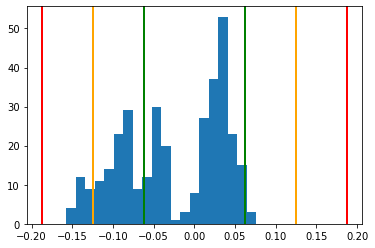

In [6]:
start_date = dt.date.today() - dt.timedelta(days=int(30))
end_date = dt.date.today()

btc = alpaca.get_crypto_bars("BTCUSD", TimeFrame.Hour, start_date, end_date).df
btc = btc[btc['exchange'] == 'CBSE'] # Keep data from only CBSE exchange
coin = alpaca.get_bars("COIN", TimeFrame.Hour, start_date, end_date).df
btc['BTC_minutely_return'] = btc['close'].pct_change().dropna()
coin['COIN_minutely_return'] = coin['close'].pct_change().dropna()
btc['BTC_return'] = btc['BTC_minutely_return'].add(1).cumprod().sub(1) # cumulative return: (1 + return_1) * (1 + return_2) * …
coin['COIN_return'] = coin['COIN_minutely_return'].add(1).cumprod().sub(1)

data = pd.DataFrame()
data["BTC_return"] = btc['BTC_return']
data["COIN_return"] = coin["COIN_return"]
data["spread"] = data["BTC_return"] - data["COIN_return"]
data["spread_std"] = data["spread"].std()
data["spread_upper_std"] = 1 * data["spread_std"]
data["spread_lower_std"] = -1 * data["spread_std"]

data.dropna(inplace=True)


In [7]:

fig1 = px.line(btc, y='BTC_return', color_discrete_sequence=['red'])
fig2 = px.line(coin, y='COIN_return', color_discrete_sequence=['blue'])
fig3 = go.Figure(data=fig1.data + fig2.data)
fig3.show()


In [9]:
fig1 = px.line(data, y='spread',  color_discrete_sequence=['green'], render_mode='svg')
fig1.update_xaxes(
    rangebreaks=[ # hide weekends
        { 'pattern': 'day of week', 'bounds': [6, 1]},
        { 'pattern': 'hour', 'bounds':[23,11]}
    ])

In [11]:

fig2 = px.line(data * 1, y=['spread_upper_std', 'spread_lower_std'], color_discrete_sequence=['cyan'], render_mode='svg')
fig3 = px.line(data * 2, y=['spread_upper_std', 'spread_lower_std'], color_discrete_sequence=['gray'], render_mode='svg')
fig4 = px.line(data * 3, y=['spread_upper_std', 'spread_lower_std'], color_discrete_sequence=['red'], render_mode='svg')

fig5 = go.Figure(data=fig1.data + fig2.data + fig3.data + fig4.data)
fig5.update_xaxes(
    rangebreaks=[
        { 'pattern': 'day of week', 'bounds': [6, 1]},
        { 'pattern': 'hour', 'bounds':[23,11]}
    ])

# Historical macro events

In [7]:
econ_events = pd.read_excel(path_macro_us_events,  parse_dates={'GMT Datetime': ['GMT Date', 'GMT Time']})
econ_events = econ_events[econ_events.Future == 'No']
econ_events.reset_index(inplace=True)

c:\Users\kalmar\.conda\envs\alpaca_env\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning:

tzname NTS identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.



Number of macro events in database

In [8]:
fig = px.histogram(econ_events, x="Short Name", title="Number of indicators values")
fig.update_layout(title_x=0.5) # location of legend

### How macro is reported after end of quarter

In [9]:
data = econ_events[econ_events['Last Observation Date'].dt.strftime('%Y-%m') == '2022-06'].sort_values(by=['GMT Datetime'])
data['GMT Datetime'] = data['GMT Datetime'].dt.date
fig = px.bar(data, x="GMT Datetime", color="Indicator Type", hover_data=['Short Name'])
fig.update_xaxes(rangebreaks=[
        { 'pattern': 'day of week', 'bounds': [6, 1]} # remove weekends
        # { 'pattern': 'hour', 'bounds':[23,11]} # remove night hours
    ]
)
# fig.update_layout(xaxis_tickformat='%d-%b')
#fig.update_xaxes(dtick="M1",tickformat="%b\n%Y")
fig.show()

### Histogram of all events

In [10]:
# If set plotly to default, this will not work
# pd.options.plotting.backend = "plotly" # Set default charting for pandas to plotly
econ_events['Actual'].hist(by=econ_events['Short Name'],figsize = (30,30))

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

with plotly

In [11]:
fig = px.histogram(econ_events, x="Actual", facet_row_spacing=0.03, nbins=20,
                    facet_col_spacing=0.03, facet_col="Short Name", facet_col_wrap=4)
fig.update_layout(autosize=False,width=1400,height=2000,)
fig.update_xaxes(matches=None,showticklabels=True)
fig.update_yaxes(matches=None,showticklabels=True)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1])) # adjusting headers

# ETFDB

In [33]:
needed_cols = ['Universe','Character', 'Compare','Ticker Symbol', 'Fund Name', 'Refinitiv_Active', 'ISIN',	'Instrument', 
'Launch Date', 'Fund Type', 'Industry', 'Geographic Focus', 'Type', 'Long-Short', 'Leverage', 'Company Market Cap']
US_ETF_ALL=pd.read_excel('D:\\Data\\Other_data\\ETFDB.xlsx',
                        sheet_name='US_ETFs',
                        skiprows=list(range(0,1)),header=1,
                        index_col='Ticker Symbol',
                        usecols=needed_cols) # read hist index components
US_ETF_ALL=US_ETF_ALL[US_ETF_ALL.Universe=="US"] # There are also ETFs traded on XMUN

In [34]:
US_ETF_ALL['Launch Date'] = pd.to_datetime(US_ETF_ALL['Launch Date'], format='%Y-%m-%d')
US_ETF_ALL['Refinitiv_Active'] = pd.to_datetime(US_ETF_ALL['Refinitiv_Active'], format='%d.%m.%Y')
active_date = US_ETF_ALL.Refinitiv_Active.max()
US_ETF_ALL=US_ETF_ALL[US_ETF_ALL.Refinitiv_Active==active_date] # focus on currently active ETFs

In [35]:
US_ETF_ALL

Universe        Character Compare  \
Ticker Symbol                                     
SPY                 US              NaN     SPY   
IVV                 US              NaN     SPY   
VOO                 US  Non_transparent     NaN   
VTI                 US  Non_transparent     NaN   
QQQ                 US              NaN     QQQ   
...                ...              ...     ...   
BRLN                US              NaN     NaN   
DSMC                US              NaN     NaN   
SRHQ                US              NaN     NaN   
NSPL                US              NaN     NaN   
FLRU                US              NaN     NaN   

                                                Fund Name Refinitiv_Active  \
Ticker Symbol                                                                
SPY                                SPDR S&P 500 ETF Trust       2022-10-12   
IVV                              iShares Core S&P 500 ETF       2022-10-12   
VOO                           Vanguard 500 Index Fund;ETF       2022-10-12   
VTI            Vanguard Total Stock Market Index Fund;ETF       2022-10-12   
QQQ                            Invesco QQQ Trust Series 1       2022-10-12   
...                                                   ...              ...   
BRLN                     BlackRock Floating Rate Loan ETF       2022-10-12   
DSMC                   Distillate Small/Mid Cash Flow ETF       2022-10-12   
SRHQ                                   SRH US Quality ETF       2022-10-12   
NSPL                          NightShares 500 1x/1.5x ETF       2022-10-12   
FLRU                             Franklin FTSE Russia ETF       2022-10-12   

                       ISIN Instrument Launch Date Fund Type  \
Ticker Symbol                                                  
SPY            US78462F1030      SPY.P  1993-01-22    Equity   
IVV            US4642872000      IVV.P  2000-05-15    Equity   
VOO            US9229083632      VOO.P  2010-09-07    Equity   
VTI            US9229087690      VTI.P  2001-05-24    Equity   
QQQ            US46090E1038     QQQ.OQ  1999-03-10    Equity   
...                     ...        ...         ...       ...   
BRLN           US0925284053     BRLN.Z  2022-10-04      Bond   
DSMC           US26922B6671     DSMC.P  2022-10-05    Equity   
SRHQ           US2103221030     SRHQ.P  2022-10-05    Equity   
NSPL           US90470L4288     NSPL.P  2022-10-06    Equity   
FLRU           US35473P7289     FLRU.P  2018-02-08    Equity   

                             Industry          Geographic Focus Type  \
Ticker Symbol                                                          
SPY                       Diversified  United States of America   No   
IVV                       Diversified  United States of America   No   
VOO                       Diversified  United States of America   No   
VTI                       Diversified  United States of America   No   
QQQ                       Diversified  United States of America   No   
...                               ...                       ...  ...   
BRLN           Corporate (Bank Loans)  United States of America  NaN   
DSMC                      Diversified  United States of America  NaN   
SRHQ                      Diversified  United States of America  NaN   
NSPL                      Diversified  United States of America  NaN   
FLRU                      Diversified                    Russia   No   

              Long-Short Leverage  Company Market Cap  
Ticker Symbol                                          
SPY                 Long       No       334641.925790  
IVV                 Long       No       278056.539588  
VOO                 Long       No       250729.545201  
VTI                 Long       No       249109.118379  
QQQ                 Long       No       148177.807848  
...                  ...      ...                 ...  
BRLN                 NaN      NaN            0.000000  
DSMC                 NaN      NaN           10.005588  
SRHQ 

In [36]:
fig = px.scatter(US_ETF_ALL, x="Launch Date", y="Company Market Cap", color="Fund Type",
                 size='Company Market Cap', hover_data=['Fund Name',US_ETF_ALL.index])
fig.show()

In [37]:
EQUITY_ETF_NOT_LEVERAGE = US_ETF_ALL[(US_ETF_ALL['Fund Type']=="Equity") & (US_ETF_ALL['Leverage']=="No") & (US_ETF_ALL['Type']!="1 Stock")] # There are also ETFs traded on XMUN
EQUITY_ETF_NOT_LEVERAGE

Universe        Character Compare  \
Ticker Symbol                                     
SPY                 US              NaN     SPY   
IVV                 US              NaN     SPY   
VOO                 US  Non_transparent     NaN   
VTI                 US  Non_transparent     NaN   
QQQ                 US              NaN     QQQ   
...                ...              ...     ...   
OAIE                US        AI-driven     NaN   
BIDS                US              NaN     NaN   
RESI                US              NaN     NaN   
SHOC                US              NaN     NaN   
FLRU                US              NaN     NaN   

                                                   Fund Name Refinitiv_Active  \
Ticker Symbol                                                                   
SPY                                   SPDR S&P 500 ETF Trust       2022-10-12   
IVV                                 iShares Core S&P 500 ETF       2022-10-12   
VOO                              Vanguard 500 Index Fund;ETF       2022-10-12   
VTI               Vanguard Total Stock Market Index Fund;ETF       2022-10-12   
QQQ                               Invesco QQQ Trust Series 1       2022-10-12   
...                                                      ...              ...   
OAIE            Optimize AI Smart Sentiment Event-Driven ETF       2022-10-12   
BIDS                    Amplify Digital & Online Trading ETF       2022-10-12   
RESI           Kelly Residential & Apartment Real Estate ETF       2022-10-12   
SHOC                             Strive US Semiconductor ETF       2022-10-12   
FLRU                                Franklin FTSE Russia ETF       2022-10-12   

                       ISIN Instrument Launch Date Fund Type  \
Ticker Symbol                                                  
SPY            US78462F1030      SPY.P  1993-01-22    Equity   
IVV            US4642872000      IVV.P  2000-05-15    Equity   
VOO            US9229083632      VOO.P  2010-09-07    Equity   
VTI            US9229087690      VTI.P  2001-05-24    Equity   
QQQ            US46090E1038     QQQ.OQ  1999-03-10    Equity   
...                     ...        ...         ...       ...   
OAIE           US81752T5772     OAIE.P  2022-06-15    Equity   
BIDS           US0321087712     BIDS.P  2021-09-21    Equity   
RESI           US48817R5081     RESI.P  2022-01-12    Equity   
SHOC           US02072L6728     SHOC.P  2022-10-06    Equity   
FLRU           US35473P7289     FLRU.P  2018-02-08    Equity   

                                      Industry          Geographic Focus  \
Ticker Symbol                                                              
SPY                                Diversified  United States of America   
IVV                                Diversified  United States of America   
VOO                                Diversified  United States of America   
VTI                                Diversified  United States of America   
QQQ                                Diversified  United States of America   
...                                        ...                       ...   
OAIE                               Diversified  United States of America   
BIDS           Financials (Financial Services)                    Global   
RESI                               Real Estate  United States of America   
SHOC               Technology (Semiconductors)  United States of America   
FLRU                               Diversified                    Russia   

                    Type Long-Short Leverage  Company Market Cap  
Ticker Symbol                                                     
SPY                   No       Long       No       334641.925790  
IVV                   No       Long       No       278056.539588  
VOO                   No       Long       No       250729.545201  
VTI                   No       Long       No       249109.118379  
QQQ                   No       Long       No       148177.807848  
...  

In [40]:
fig = px.scatter(EQUITY_ETF_NOT_LEVERAGE, x="Geographic Focus", y="Industry", color="Type",
                 # size=count(),
                 hover_data=['Fund Name',EQUITY_ETF_NOT_LEVERAGE.index])
fig.show()

KeyError: (nan, '', '', '', '')

# Senator Transactions (FMP)

In [4]:
def get_senators_for_ticker(symbol):
    specific_url = f'v4/senate-disclosure?symbol={symbol}&apikey={fmp_api_key}#'
    response = urlopen(base_fmp_url+specific_url)
    data = response.read().decode("utf-8")
    data_df = pd.json_normalize(json.loads(data))
    return data_df

In [11]:
fmp_senators_deals = pd.read_excel(path_senators)
print('Status of data: ', dt.datetime.fromtimestamp(os.path.getmtime(path_senators)).strftime('%Y-%m-%d %H:%M:%S'))

NameError: name 'path_senators' is not defined

### Downloading trades of senators from FMP
If the database doesn't exist use the steps below to get it

In [5]:
repository = Github(github_strat_token).get_user().get_repo(dedicated_repo)
SP500_file = repository.get_contents(gh_csv_stocks)
sp500 = pd.read_csv(io.StringIO(SP500_file.decoded_content.decode()))
ALL_SYMBOLS = sp500.symbol.to_list()

In [7]:
# could take up to 6 min to get 8ths rows
fmp_senators_deals = pd.concat((get_senators_for_ticker(ticker) for ticker in ALL_SYMBOLS)).reset_index(drop=True)

In [8]:
fmp_senators_deals['amount'] = fmp_senators_deals['amount'].str.replace('[\$, ]', '', regex=True)
fmp_senators_deals[['From', 'To']] = fmp_senators_deals['amount'].str.split('-', expand=True)
fmp_senators_deals['From'] = fmp_senators_deals['From'].astype(int)

bins = [0, 100000, 250000, 500000, 1000000, np.inf]
labels = ['small','normal', 'big', 'very big', 'huge']
fmp_senators_deals['amount'] = pd.cut(fmp_senators_deals['From'], bins=bins, labels=labels)
needed_cols = ['disclosureDate', 'transactionDate', 'owner','ticker', 'assetDescription', 'type', 'amount', 'representative', 'capitalGainsOver200USD']
fmp_senators_deals = fmp_senators_deals[needed_cols]

In [ ]:
fmp_senators_deals.to_excel("senator_transactions.xlsx", index=False)

In [14]:
fmp_senators_deals['disclosureDate'] = pd.to_datetime(fmp_senators_deals['disclosureDate'], errors='coerce')
fmp_senators_deals['transactionDate'] = pd.to_datetime(fmp_senators_deals['transactionDate'], errors='coerce')
fmp_senators_deals = fmp_senators_deals.dropna(subset=['transactionDate','disclosureDate'])
fmp_senators_deals['ReportingLag'] = (fmp_senators_deals['disclosureDate'] - fmp_senators_deals['transactionDate']).dt.days

In [46]:
# filter out small transactions & transactions which were reported much later than occured
not_small_transcations = fmp_senators_deals[(fmp_senators_deals['amount'] != 'small') & (fmp_senators_deals['RaportingLag']<100)].reset_index(drop=True)


In [34]:

exchange_histogram = px.bar(not_small_transcations, x="representative", color = 'type')
exchange_histogram.update_layout(
    title="Number of >$100k transactions by senator over last 3 years",
    yaxis_title="Number of trades",
    title_x=0.5)

In [35]:
exchange_histogram = px.bar(not_small_transcations[not_small_transcations['type']=='purchase'], x="ticker")
exchange_histogram.update_layout(
    title="Number of >$100k transactions by senator over last 3 years",
    yaxis_title="Number of trades",
    title_x=0.5)

In [45]:
fig = px.histogram(not_small_transcations, x="RaportingLag", 
                   facet_row_spacing=0.03, facet_col_spacing=0.03
                #   nbins=20,
                    , facet_col="type", facet_col_wrap=3)
# fig.update_layout(autosize=False,width=1400,height=2000,)
# fig.update_xaxes(matches=None,showticklabels=True)
# fig.update_yaxes(matches=None,showticklabels=True)
fig.update_layout(
    title="Number of days between the transaction and reporting",
    xaxis_title="Days",
    yaxis_title="Number of trades",
    title_x=0.5)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1])) # adjusting headers


In [60]:
result = not_small_transcations.groupby('ticker')['transactionDate'].agg(['min', 'max']).reset_index(drop=True)
result['max'] = result['max'] + pd.Timedelta(days=90)
all_tickers = result['ticker'].to_list()

### Getting daily data from Alpaca

In [61]:
def get_data(symbol):
    min = result.loc[result['ticker'] == symbol, 'min'].iat[0]
    max = result.loc[result['ticker'] == symbol, 'max'].iat[0]
    bars_request_params = StockBarsRequest(symbol_or_symbols=symbol, 
                                            start = min, end = max, 
                                            timeframe=TimeFrame.Day, 
                                            adjustment= Adjustment.ALL,
                                            feed = DataFeed.SIP)
    return stock_client.get_stock_bars(bars_request_params).df


daily_data = pd.concat((get_data(ticker) for ticker in all_tickers)).reset_index(drop=True)
daily_data.timestamp = daily_data.timestamp.dt.date


### Adding returns after transactions

In [89]:
import pandas as pd
from pandas.tseries.offsets import DateOffset

def calculate_returns(events_df, 
                      stock_prices_df, 
                      ticker_col_events, 
                      ticker_col_stocks, 
                      date_col_events, 
                      date_col_stocks, 
                      price_col_stocks,
                      days_list):
    # Initialize return columns in events_df
    for days in days_list:
        events_df[f'Return_{days}_from_{date_col_events}'] = None
    
    # Iterate through each event
    for idx, event in events_df.iterrows():
        ticker = event[ticker_col_events]
        event_date = event[date_col_events]
        dates_for_ticker = stock_prices_df.loc[stock_prices_df[ticker_col_stocks] == ticker, date_col_stocks]

        # Find the index of the event_date or next 4 dates in dates_for_ticker
        event_date_index = None
        for i in range(5):
            try:
                event_date_index = dates_for_ticker[dates_for_ticker == event_date + DateOffset(days=i)].index[0]
                break
            except IndexError:
                pass

        prices_for_ticker = stock_prices_df.loc[stock_prices_df[ticker_col_stocks] == ticker, price_col_stocks]

        # Calculate the return for each period in days_list
        try:
            price_event = prices_for_ticker.loc[event_date_index]
            for days in days_list:
                price_days_after = prices_for_ticker.loc[event_date_index + days]
                events_df.at[idx, f'Return_{days}_from_{date_col_events}'] = (price_days_after - price_event) / price_event
        except:
            # Handle case when there are less than specified days after the event date in the data
            pass

    return events_df

In [95]:
days_list = [5, 30]
not_small_transcations = calculate_returns(not_small_transcations, daily_data, 'ticker', 'symbol', 'transactionDate', 'timestamp', 'close', days_list)
not_small_transcations = calculate_returns(not_small_transcations, daily_data, 'ticker', 'symbol', 'disclosureDate', 'timestamp', 'close', days_list)

C:\Users\kalmar\AppData\Local\Temp\ipykernel_20004\660858524.py:26: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



In [99]:
not_small_transcations

disclosureDate transactionDate  owner ticker  \
0       2023-04-06      2023-03-17   self   AAPL   
1       2022-07-14      2022-06-17   self   AAPL   
2       2022-06-03      2022-05-13   self   AAPL   
3       2022-06-03      2022-05-24   self   AAPL   
4       2022-04-21      2022-03-22  joint   AAPL   
..             ...             ...    ...    ...   
316     2021-08-14      2021-07-19          GNRC   
317     2021-03-10      2021-02-09          GNRC   
318     2021-06-20      2021-05-17           ALK   
319     2021-04-19      2021-03-01  joint    DXC   
320     2021-04-19      2021-03-01   self    DXC   

                                      assetDescription          type  \
0    Apple Inc - Excercise 100 call options purchas...      purchase   
1    Apple Inc - 50 CALL options @ $100 expiry 06/1...  sale_partial   
2    Apple Inc - 100 Call options strike of $80 exp...      purchase   
3    Apple Inc - 50 Call options strike of $80 expi...      purchase   
4                                            Apple Inc     sale_full   
..                                                 ...           ...   
316                               Generac Holdings Inc     sale_full   
317                               Generac Holdings Inc      purchase   
318                              Alaska Air Group, Inc     sale_full   
319                                  DXC Technology Co      purchase   
320                                  DXC Technology Co      purchase   

       amount     representative capitalGainsOver200USD  RaportingLag  \
0    very big       Nancy Pelosi                  False            20   
1      normal       Nancy Pelosi                  False            27   
2    very big       Nancy Pelosi                  False            21   
3         big       Nancy Pelosi                  False            10   
4    very big        Kim Schrier                  False            30   
..        ...                ...                    ...           ...   
316    normal  James R. Langevin                  False            26   
317    normal  James R. Langevin                  False            29   
318       big    Victoria Spartz                  False            34   
319    normal  Michael T. McCaul                  False            49   
320    normal  Michael T. McCaul                  False            49   

    Return_5_from_transactionDate Return_30_from_transactionDate  \
0                        0.033919                       0.094134   
1                         0.07677                       0.216241   
2                       -0.064629                      -0.065654   
3                        0.059485                       0.047588   
4                        0.060094                       -0.01659   
..                            ...                            ...   
316                      0.023949                       0.019459   
317                      0.289447                        0.07737   
318                     -0.033766                      -0.161016   
319                      0.079353                       0.199923   
320                      0.079353                       0.199923   

    Return_5_from_disclosureDate Return_30_from_disclosureDate  
0                       0.003345                       0.06556  
1                       0.046345                      0.146758  
2                      -0.056809                      0.038611  
3                      -0.056809                      0.038611  
4                      -0.016708                     -0.125129  
..                           ...                           ...  
316                     0.011799                      0.036934  
317                     0.006423                      0.022766  
318                    -0.054906                     -0.120424  
319                     0.000316                          None  
320                     0.000316                          None  

[321 rows x 14 columns]

### Visualize returns

In [105]:
Returns_graph = px.scatter(not_small_transcations[not_small_transcations['type']=='purchase'], 
                           x='RaportingLag', y='Return_5_from_disclosureDate', 
                            color = "representative", 
                            # labels={"color": "Sector"}, 
                            hover_data=["representative", "amount", "ticker"],
                            title="Returns")
Returns_graph

# Insiders (FMP)

### Downloading insiders trades from FMP (if the database doesn't exist)

Getting all symbols in scope:

In [106]:
repository = Github(github_strat_token).get_user().get_repo(dedicated_repo)
SP500_file = repository.get_contents(gh_csv_stocks)
sp500 = pd.read_csv(io.StringIO(SP500_file.decoded_content.decode()))
ALL_SYMBOLS = sp500.symbol.to_list()

Calling FMP (takes 9 min to get 60ths rows)

In [107]:
def get_insiders_for_ticker(symbol):
    specific_url = f'v4/insider-trading?symbol={symbol}&page=0&apikey={fmp_api_key}'
    response = urlopen(base_fmp_url+specific_url)
    data = response.read().decode("utf-8")
    data_df = pd.json_normalize(json.loads(data))
    return data_df

insider_trans_stock = pd.concat((get_insiders_for_ticker(ticker) for ticker in ALL_SYMBOLS)).reset_index(drop=True)

In [109]:
# insider_trans_stock.drop(['securityName','link','reportingCik','formType'], axis=1, inplace=True)
insider_trans_stock.drop(['link'], axis=1, inplace=True)
insider_trans_stock = insider_trans_stock.dropna(subset=['transactionType'])
insider_trans_stock['securitiesTransacted'] = round(insider_trans_stock['securitiesTransacted'].fillna(0).astype(int),0)
insider_trans_stock = insider_trans_stock[insider_trans_stock['securitiesTransacted'] != 0]
insider_trans_stock['securitiesOwned'] = round(insider_trans_stock['securitiesOwned'].fillna(0).astype(int),0)
insider_trans_stock['price'] = round(insider_trans_stock['price'].fillna(0).astype(float),2)
insider_trans_stock['amount'] = insider_trans_stock['price'] * insider_trans_stock['securitiesTransacted']

In [167]:
# insider_trans_stock_backup = insider_trans_stock.copy()
# insider_trans_stock = insider_trans_stock_backup.copy()

In [118]:
insider_trans_stock['filingDate'] = pd.to_datetime(insider_trans_stock['filingDate'])
insider_trans_stock['filingDate'] = insider_trans_stock['filingDate'].dt.tz_localize('US/Eastern')
insider_trans_stock['filingDate CET'] = insider_trans_stock['filingDate'].dt.tz_convert('Europe/Berlin')
insider_trans_stock['filingDate CET'] = insider_trans_stock['filingDate CET'].dt.tz_localize(None)
insider_trans_stock['filingDate'] = insider_trans_stock['filingDate'].dt.tz_localize(None)
insider_trans_stock['transactionDate'] = pd.to_datetime(insider_trans_stock['transactionDate'], errors='coerce')
insider_trans_stock['ReportingLag'] = (insider_trans_stock['filingDate'] - insider_trans_stock['transactionDate']).dt.days

In [154]:
from collections import OrderedDict # needed as the order is important

mapping_insiders = OrderedDict({
    '10':'10 perc owner',
    'CEO':'CEO',
    'chief ex':'CEO',
    'CFO':'CFO',
    'COO':'COO',
    })

mapping_SecType = OrderedDict({
    'phan':'Phantom Stock',
    'pay':'Payout on Restr Defer Perf Stock Unit',
    'restri':'Restr Defer Perf Stock Unit',
    'RSU':'Restr Defer Perf Stock Unit',
    'PSU':'Restr Defer Perf Stock Unit',
    'perf':'Restr Defer Perf Stock Unit',
    'defe':'Restr Defer Perf Stock Unit',
    'MSU':'Restr Defer Perf Stock Unit',
    'DSU':'Restr Defer Perf Stock Unit',
    'divi':'Dividend Equivalent Units',
    'unit':'Restr Defer Perf Stock Unit',
    'conv':'Convertibles',
    'pref':'Preffered Stock',
    'appre':'Stock Appreciation Rights',
    'buy':'Right to Buy',
    'purch':'Right to Buy',
    'acq':'Right to Buy',
    'rights to':'Right to Buy',
    'option':'Right to Buy',
    'warr':'Right to Buy',
    'obli':'Obligation to Sell',
    'sell':'Right to Sell',
    'comm':'Common Stock',
    'ordi':'Common Stock',
})

insider_trans_stock['InsiderType'] = np.nan  # Initialize new column with NaNs
for key, value in mapping_insiders.items():
    insider_trans_stock.loc[insider_trans_stock['typeOfOwner'].str.contains(key, case=False, na=False) & insider_trans_stock['InsiderType'].isna(), 'InsiderType'] = value
insider_trans_stock['InsiderType'].fillna('Other', inplace=True)

insider_trans_stock['SecurityType'] = np.nan  # Initialize new column with NaNs
for key, value in mapping_SecType.items():
    insider_trans_stock.loc[insider_trans_stock['securityName'].str.contains(key, case=False, na=False) & insider_trans_stock['SecurityType'].isna(), 'SecurityType'] = value
insider_trans_stock['SecurityType'].fillna('Other', inplace=True)


In [156]:
insider_trans_stock.to_excel("insider_transactions_fmp.xlsx", index=False)

### Reading existing excel file with insider transactions

In [ ]:
insider_trans_stock = pd.read_excel(path_senators)
print('Status of data: ', dt.datetime.fromtimestamp(os.path.getmtime(path_senators)).strftime('%Y-%m-%d %H:%M:%S'))

In [159]:
insider_trans_stock

symbol           filingDate transactionDate reportingCik  \
0       AAPL  2023-05-18 18:32:21      2023-05-16   0001051401   
1       AAPL  2023-05-12 18:30:34      2023-05-10   0001462356   
2       AAPL  2023-05-10 18:30:22      2023-05-08   0001631982   
3       AAPL  2023-04-18 18:31:39      2023-04-15   0001631982   
4       AAPL  2023-04-18 18:31:39      2023-04-15   0001631982   
...      ...                  ...             ...          ...   
57573    LNC  2022-10-04 16:17:49      2022-09-30   0001303417   
57574    LNC  2022-08-12 16:18:12      2022-08-10   0001941164   
57575    LNC  2022-08-12 16:17:22      2022-08-10   0001937707   
57578    LNC  2022-07-05 16:27:17      2022-06-30   0001303417   
57579    LNC  2022-07-05 16:26:41      2022-06-30   0001228946   

      transactionType  securitiesOwned  companyCik       reportingName  \
0              G-Gift                0  0000320193         JUNG ANDREA   
1              G-Gift           422313  0000320193  Adams Katherine L.   
2              S-Sale            33946  0000320193         KONDO CHRIS   
3            M-Exempt            42422  0000320193         KONDO CHRIS   
4            F-InKind            38038  0000320193         KONDO CHRIS   
...               ...              ...         ...                 ...   
57573         A-Award            20995  0000059558  Connelly Deirdre P   
57574         A-Award            27957  0000059558  Reid James Waltman   
57575         A-Award            15493  0000059558       Grove Matthew   
57578         A-Award            19880  0000059558  Connelly Deirdre P   
57579         A-Award            61081  0000059558      JOHNSON ERIC G   

                                    typeOfOwner acquistionOrDisposition  \
0                                      director                       D   
1                officer: SVP, GC and Secretary                       D   
2         officer: Principal Accounting Officer                       D   
3         officer: Principal Accounting Officer                       A   
4         officer: Principal Accounting Officer                       D   
...                                         ...                     ...   
57573                                  director                       A   
57574    director: EVP Head of Wrkplc Solutions                       A   
57575  director: EVP Head of Life Annuities LFN                       A   
57578                                director:                        A   
57579                                director:                        A   

      formType  securitiesTransacted   price  \
0            4                 68642    0.00   
1            4                  2900    0.00   
2            4                  4092  173.26   
3            4                 10792    0.00   
4            4                  4384  165.21   
...        ...                   ...     ...   
57573        4                   939   43.91   
57574        4                 27957    0.00   
57575        4                 15493    0.00   
57578        4                   881   46.77   
57579        4                   881   46.77   

                               securityName     amount InsiderType  \
0                              Common Stock       0.00       Other   
1                              Common Stock       0.00       Other   
2                              Common Stock  708979.92       Other   
3                              Common Stock       0.00       Other   
4                              Common Stock  724280.64       Other   
...                                     ...        ...         ...   
57573                    Phantom Stock Unit   41231.49       Other   
57574  Employee Stock Option (right to buy)       0.00       Other   
57575                          Common Stock       0.00       Other   
57578                    Phantom Stock Unit   41204.37       Other   
57579                    Phantom Stock Unit   41204.37       Other   

     

## Visualize stuff

In [124]:
insider_trans_stock = insider_trans_stock.dropna(subset=['transactionType'])
insider_trans_stock['symbol'].groupby(insider_trans_stock['transactionDate'].dt.year).count()

transactionDate
2002        1
2011       15
2012        1
2014        6
2015       26
2016       29
2017       24
2018       72
2019      100
2020      351
2021     1990
2022    15351
2023    39544
2024       31
2025       19
2026       18
2027        2
Name: symbol, dtype: int64

### Submissions by hour
A lot of insider trading is reported after market close (after 22:00 in Munich) - so I have one hour

In [126]:
fig3 = px.bar(insider_trans_stock['symbol'].groupby([insider_trans_stock['filingDate CET'].dt.hour]).count(),
            title="Number of insider trading releases by clock hour in Munich")
fig3.update_layout(showlegend=False,title_x=0.5)

In [129]:
after_hours_releases = insider_trans_stock[(insider_trans_stock['filingDate CET'].dt.hour >= 22) & (insider_trans_stock['filingDate CET'].dt.hour < 23)]
fig4 = px.bar(after_hours_releases['symbol'].groupby([after_hours_releases['filingDate CET'].dt.minute]).count(),
            title="Number of insider trading releases between 22:00 and 23:00 by minute in Munich")
fig4.update_layout(showlegend=False,title_x=0.5)

### Volumes

In [170]:
dispositions_in_2023 = insider_trans_stock[(insider_trans_stock['acquistionOrDisposition']=="D") & (insider_trans_stock['transactionDate'].dt.year ==2023)].groupby('symbol').count()
dispositions_in_2023

filingDate  transactionDate  reportingCik  transactionType  \
symbol                                                               
A                3                3             3                3   
AAP             33               33            33               33   
AAPL            46               46            46               46   
ABBV            59               59            59               59   
ABC             36               36            36               36   
...            ...              ...           ...              ...   
ZG              46               46            46               46   
ZION            26               26            26               26   
ZM              73               73            73               73   
ZS               4                4             4                4   
ZTS             36               36            36               36   

        securitiesOwned  companyCik  reportingName  typeOfOwner  \
symbol                                                            
A                     3           3              3            3   
AAP                  33          33             33           33   
AAPL                 46          46             46           46   
ABBV                 59          59             59           59   
ABC                  36          36             36           36   
...                 ...         ...            ...          ...   
ZG                   46          46             46           46   
ZION                 26          26             26           26   
ZM                   73          73             73           73   
ZS                    4           4              4            4   
ZTS                  36          36             36           36   

        acquistionOrDisposition  formType  securitiesTransacted  price  \
symbol                                                                   
A                             3         3                     3      3   
AAP                          33        33                    33     33   
AAPL                         46        46                    46     46   
ABBV                         59        59                    59     59   
ABC                          36        36                    36     36   
...                         ...       ...                   ...    ...   
ZG                           46        46                    46     46   
ZION                         26        26                    26     26   
ZM                           73        73                    73     73   
ZS                            4         4                     4      4   
ZTS                          36        36                    36     36   

        securityName  amount  InsiderType  SecurityType  
symbol                                                   
A                  3       3            3             3  
AAP               33      33           33            33  
AAPL              46      46           46            46  
ABBV              59      59           59            59  
ABC               36      36           36            36  
...              ...     ...          ...           ...  
ZG                46      46           46            46  
ZION              26      26           26            26  
ZM                73      73           73            73  
ZS                 4       4            4             4  
ZTS               36      36           36            36  

[575 rows x 16 columns]

In [168]:
dispositions_in_2023 = insider_trans_stock[(insider_trans_stock['acquistionOrDisposition']=="D") & (insider_trans_stock['transactionDate'].dt.year ==2023)].groupby('symbol')
fig = px.bar(, x="symbol")
fig.update_layout(
    title="Number of >$100k transactions by senator over last 3 years",
    yaxis_title="Number of trades",
    title_x=0.5)